### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 GeneralizedAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SaliencybasedGeneralizedAnomalyScoreV2, 
                 FFTbasedGeneralizedAnomalyScoreV2, KMeansAnomalyScoreV2, MatrixProfileAnomalyScore)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
mat0='MatrixProfileAnomalyScore'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'
matA0='matAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000
mat_break = 1



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:
# set up a db object with a FileModelStore to support scaling
#with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
#    credentials = json.loads(F.read())
#db_schema=None
#fm = FileModelStore()
#db = Database(credentials=credentials, model_store=fm)
#print (db)

db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2022-02-23T19:09:04.711 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [70]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./data/PDS_MMANOMALY_DM_AZURE_202202231039.csv', index_col=False)
df_i.rename(columns={'TIMESTAMP':'timestamp','INPUTVALUE':'Temperature'}, inplace=True)

df_i['entity']='MyRoom'
df_i['timestamp'] = pd.to_datetime(df_i['timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')
#df_i[Temperature]=df_i['wss2speed']
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='ORIGINALINDEX')
df_i = df_i.drop_duplicates(subset='ORIGINALINDEX')
df_i = df_i.set_index(['entity','timestamp']).dropna()


In [81]:
# Now run the anomaly functions as if they were executed in a pipeline

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

slide = 12
winsize = 120

ll = np.arange(0,3996,slide)
geni = GeneralizedAnomalyScore(Temperature, 12, gen)
et = geni._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
geni._entity_type = et

res = []

for l in ll:
    df_k = df_i[l:min(l+winsize,3996)].copy()
    print(l)
    df_k = geni.execute(df=df_k)
    res.append(df_k[gen].values[:slide])

#df_i[gen] = np.concatenate(res)

2022-02-23T19:43:23.748 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
0
2022-02-23T19:43:23.750 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
12
2022-02-23T19:43:23.793 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
24
2022-02-23T19:43:23.825 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
36
2022-02-23T19:43:23.857 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
48
2022-02-23T19:43:23.887 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
60
2022-02-23T19:43:23.918 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
72
2022-02-23T19:43:23.950 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
84
2022-02-23T19:43:23.987 INFO mmfunctions.anomaly.execute db is <__ma

840
2022-02-23T19:43:26.053 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
852
2022-02-23T19:43:26.086 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
864
2022-02-23T19:43:26.120 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
876
2022-02-23T19:43:26.153 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
888
2022-02-23T19:43:26.187 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
900
2022-02-23T19:43:26.223 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
912
2022-02-23T19:43:26.256 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
924
2022-02-23T19:43:26.289 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
936
2022-02-23T19:43:26.323 INFO mmfunctions.anomaly.execute db 

1680
2022-02-23T19:43:28.493 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1692
2022-02-23T19:43:28.527 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1704
2022-02-23T19:43:28.561 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1716
2022-02-23T19:43:28.597 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1728
2022-02-23T19:43:28.632 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1740
2022-02-23T19:43:28.666 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1752
2022-02-23T19:43:28.700 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1764
2022-02-23T19:43:28.732 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
1776
2022-02-23T19:43:28.765 INFO mmfunctions.anomaly.ex

2520
2022-02-23T19:43:30.910 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2532
2022-02-23T19:43:30.945 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2544
2022-02-23T19:43:30.980 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2556
2022-02-23T19:43:31.014 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2568
2022-02-23T19:43:31.047 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2580
2022-02-23T19:43:31.080 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2592
2022-02-23T19:43:31.114 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2604
2022-02-23T19:43:31.147 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
2616
2022-02-23T19:43:31.182 INFO mmfunctions.anomaly.ex

3360
2022-02-23T19:43:33.308 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3372
2022-02-23T19:43:33.342 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3384
2022-02-23T19:43:33.376 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3396
2022-02-23T19:43:33.411 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3408
2022-02-23T19:43:33.444 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3420
2022-02-23T19:43:33.477 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3432
2022-02-23T19:43:33.509 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3444
2022-02-23T19:43:33.541 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fcc112ffac0>
3456
2022-02-23T19:43:33.573 INFO mmfunctions.anomaly.ex

/home/markus/.local/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/markus/.local/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/markus/.local/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/markus/.local/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/markus/.local/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


KeyError: 'TemperatureGeneralizedScore'

In [ ]:
df_i[gen] = np.concatenate(res)

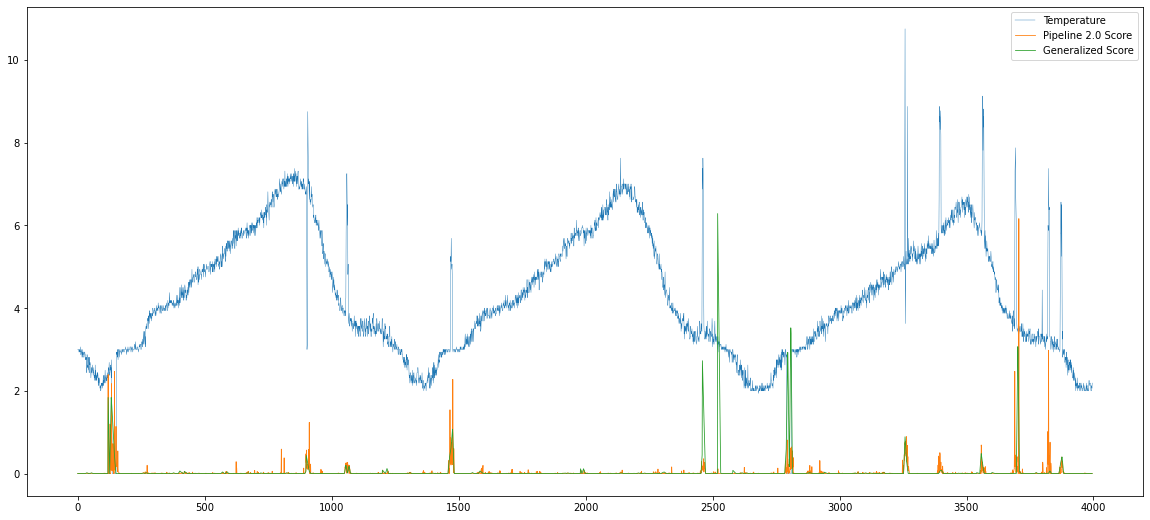

In [84]:
rg = range(df_i['Temperature'].size)
fig = plt.figure(figsize=(20, 9))

plt.plot(rg, df_i[Temperature], lw=0.4, label='Temperature')
plt.plot(rg, df_i['SCORE']/100, lw=0.8, label='Pipeline 2.0 Score');
plt.plot(rg, df_i[gen]/100, lw=0.8, label='Generalized Score');
plt.legend()

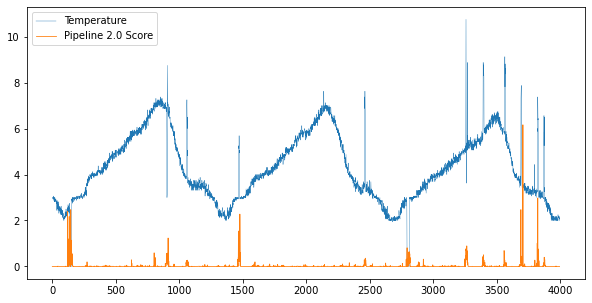

In [83]:
rg = range(df_i['Temperature'].size)
fig = plt.figure(figsize=(10, 5))

plt.plot(rg, df_i[Temperature], lw=0.4, label='Temperature')
plt.plot(rg, df_i['SCORE']/100, lw=0.8, label='Pipeline 2.0 Score');
#plt.plot(rg, df_i[gen]/10, lw=0.8, label='Generalized Score');
plt.legend()